In [1]:
import numpy as np
import jax.numpy as jnp
from matplotlib import pyplot as plt
import jax
from jax import grad, hessian, jit, vmap
from jax.nn import celu
import time
from functools import partial
from IPython.display import clear_output
import threading


hbar = 1
m = 1
omega = 1


In [3]:
class Network:
    #[1, 5, 10, 10, 10, 10, 5, 1]
    def __init__(self, node_counts=[1,50,50, 1]):
        # defining the structure of the neural network
        self.num_layers = len(node_counts)
        # the number of nodes for each layer
        self.node_counts = node_counts
        # the total number of weights
        self.params_length = 0
        for i in range(self.num_layers - 1):
            self.params_length += node_counts[i] * node_counts[i + 1]
            i+=1
        # the list that stores the weight matrices (index 0 is the connections from the input to the first hidden layer)
        self.weights = []
        # storage for all the biases
        self.biases = []
        
        # generate weight matrices with the correct sizes, and random elements
        for i in range(self.num_layers - 1):
            self.weights.append(np.random.randn(node_counts[i + 1], node_counts[i]) * np.sqrt(1. / (node_counts[i + 1])))
        self.weights = np.array(self.weights, dtype=object)
        
        # generate the bias arrays
        for i in range(self.num_layers - 1):
            temp = np.random.randn(node_counts[i + 1]) * np.sqrt(1. / node_counts[i + 1])
            self.biases.append(temp[:, None])
        self.biases = np.array(self.biases, dtype=object)
        # get the shape for reshaping a 1d array to this later
        self.dimensions = []
        for m in self.weights:
            self.dimensions.append(m.shape)

    # define the activation function that we use for the layers
    @partial(jit, static_argnums=[0])
    def l_act(self, x):
        return celu(x)
        #return 1.0 / (1.0 + jnp.exp(-x))    
    # define the activation function for the output
    @partial(jit, static_argnums=[0])
    def o_act(self, x):
        return celu(x)
        #return x
        #return 1.0 / (1.0 + jnp.exp(-x))
    
    @partial(jit, static_argnums=(0,))
    def conv1d(self):
        flattened = []
        # loop through each matrix
        for m in range(self.num_layers - 1):
            mat = self.weights[m]
            for i in range(mat.shape[0]):
                for j in range(mat.shape[1]):
                    flattened.append(mat[i][j])
        for m in range(self.num_layers - 1):
            # add the biases onto the end
            bias = self.biases[m]
            for element in bias:
                flattened.append(element)
        return jnp.array(flattened)
        
    @partial(jit, static_argnums=(0,))
    def convnd(self, params):
        ret = []
        ret_bias = []
        # the last index of the matrix
        max_ind = 0
        prev_ind = 0
        for dim in self.dimensions:
            max_ind += dim[0]*dim[1]
            temp = params[prev_ind : max_ind]
            prev_ind = max_ind
            ret.append(jnp.array(temp).reshape(dim))
        biases_flattened = params[max_ind :]
        # now reconstruct the bias matrices
        # print(biases_flattened)
        ind = 0
        for i in range(self.num_layers - 1):
            ret_bias.append((biases_flattened[ind: ind + self.node_counts[i + 1]])[:, None])
            ind += self.node_counts[i + 1]
        return ret, ret_bias


    # passing inputs into the neural network and getting an output
    @partial(jit, static_argnums=[0])
    def output(self, coords, params):
        # format the parameters as weights
        c = self.convnd(params)
        self.weights = c[0]
        self.biases = c[1]
        # compute the output of the neural network
        for i in range(self.num_layers - 1):
            w = jnp.array(self.weights[i])
            b = jnp.array(self.biases[i])
            # print(w)
            # print(b)
            # if its the first layer, dot it against the input and use the activation function
            if i == 0:
                temp = self.l_act(jnp.dot(w, coords))
            elif (i < self.num_layers):
                
                temp = self.l_act(jnp.dot(w, temp) + b)
            else:
                # on the output layer we use the output activation function
                temp = self.o_act(jnp.dot(w, temp) + b)
        # print("output:" + str(time.time() -  start))
        return temp[0]

# create the network object
nn = Network()

@jit
def psi(coords, params):
    return jnp.exp(-nn.output(coords, params)[0]) * jnp.exp(-coords**2)

def osample(params, num_samples=10**3, thermalization_steps=200, skip_count=10):
    outputs = []
    # e_plots = []
    coords_t = np.random.uniform(-5,5)
    for step in range(num_samples*skip_count + thermalization_steps + 1):
        coords_prime = coords_t + np.random.uniform(-5,5)
        # e_plots.append(Hpsi(coords_prime, params, omega))
        ar = psi(coords_prime, params)**2/psi(coords_t, params)**2
        # a_r.append(ar)
        if (np.random.uniform(0,1) < ar):
            coords_t = coords_prime
            
        if (step > thermalization_steps):
            if (step % skip_count == 0):
                outputs.append(coords_t)
    return jnp.array(outputs)

@jit
def sample_body(coords_t, params, key):    
    gen_rand = jax.random.uniform(key, minval=-5, maxval=5)
    new_key, subkey = jax.random.split(key)
    del key
    
    # gen_rand = np.random.uniform(-5,5)
    coords_prime = coords_t + gen_rand
    temp_rand = jax.random.uniform(subkey, minval=0, maxval=1)
    # temp_rand = np.random.uniform(0,1)
    return (jax.lax.cond(temp_rand < psi(coords_prime, params)**2/psi(coords_t, params)**2, lambda x, y: x, lambda x, y : y, coords_prime, coords_t), new_key)

def sample(params, num_samples=10**3, thermalization_steps=200, skip_count=10, key=jax.random.PRNGKey(np.random.randint(0,100))):
    outputs = []
    # e_plots = []
    coords_t = np.random.uniform(-5,5)
    for step in range(num_samples*skip_count + thermalization_steps + 1):
        coords_t, key = sample_body(coords_t, params, key)
        if ((step > thermalization_steps) & (step % skip_count == 0)):
            outputs.append(coords_t)
    return jnp.array(outputs)

# second derivative of the wavefunction with respect to the coordinate
ddpsi = jit(grad(jit(grad(psi, 0, allow_int = True)), 0, allow_int = True))

@jit
def Hpsi(coords, params, omega):
    return (m*.5*omega**2*coords**2) - hbar**2 / (2*m) * jnp.sum(ddpsi(coords, params)) * 1/psi(coords, params)

venergy = vmap(Hpsi, in_axes=(0, None, None), out_axes=0)

@jit
def logpsi(coords, params):
    return jnp.log(psi(coords, params))

# define the derivative with respect to every parameter of the log of psi:
dlogpsi_dtheta_stored = jit(grad(logpsi, 1))

vlog_term = jit(vmap(dlogpsi_dtheta_stored, in_axes=(0, None), out_axes=0))

vboth = vmap(jnp.multiply, in_axes=(0, 0), out_axes=0)

def gradient(params, omega, num_samples=10**3):
    # get the samples
    samples = sample(params, num_samples)
    psiHpsi = venergy(samples, params, omega)
    logs = vlog_term(samples, params)

    energy = 1/num_samples * jnp.sum(psiHpsi)
    print(energy)
    log_term = 1/num_samples * jnp.sum(logs,0)

    both = 1/num_samples * jnp.sum(vboth(psiHpsi, logs),0)

    gradient_calc = (2 * both - 2*energy * log_term)
    return gradient_calc, energy

def avg_energy(params, omega, num_samples = 10**3):
    samples = sample(params, num_samples)
    psiHpsi = venergy(samples, params, omega)
    return 1/num_samples * jnp.sum(psiHpsi)


weight1 = []
last_bias = []
energies = []
def vgrad_opt(start_params, omega, num_samples=10**3, learning_rate=.1, max_iterations=10000, tolerance=.000001):
    params = start_params
    hist = [start_params]

    for it in range(max_iterations):
        clear_output(wait=True)
        print("iteration " + str(it))
        gr = gradient(params, omega, num_samples)
        energies.append(gr[1])
        diff = jnp.asarray((learning_rate * gr[0]))
        #print(diff)
        # make a step in the direction opposite the gradient
        params = params - diff
        #weight1.append(params[0])
        #last_bias.append(params[-1])
        
        # print(params)
        hist.append(params)
    return hist


In [4]:
xs = np.linspace(-5,5,1000)
start_params = nn.conv1d()
#print(start_params)

ysi = [psi(x, start_params) for x in xs]
optd = vgrad_opt(start_params, omega)
# plt.plot(weight1)
# plt.plot(last_bias)
# plt.show()
# xs = np.linspace(-5,5,1000)
# inp = [1.0,1.0,1.0]
# ysi = [psi(x, inp) for x in xs]
# optd = vgrad_opt(jnp.array(inp, float), omega)

#print(optd[-1])

iteration 9999
0.5021616


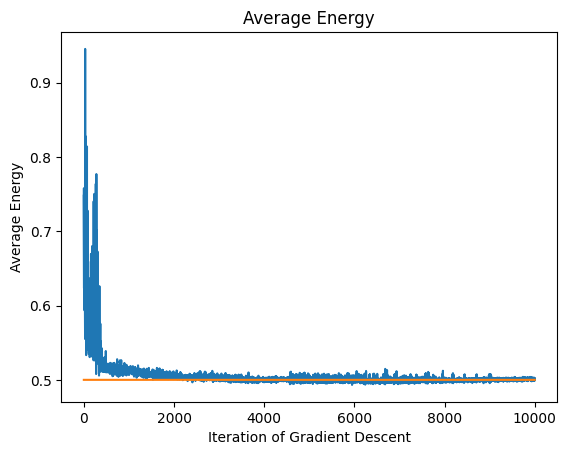

In [5]:
# plot the energy over the course of the optimization
# ys = []
# for param in optd:
#     ys.append(avg_energy(param, omega,10**3))

plt.title("Average Energy")
plt.xlabel("Iteration of Gradient Descent")
plt.ylabel("Average Energy")
plt.plot(np.arange(0,len(optd[1:])), energies)
plt.plot(np.arange(0, len(optd[1:])), [.5 for x in np.arange(0, len(optd[1:]))])
plt.show()

In [ ]:

samples = sample(nn.conv1d())
# print(len(samples[0]))

# print(np.average(a_r))
plt.hist(samples)
plt.show()
# plt.plot(samples[1])
# plt.title("Energy vs step count")
# plt.xlim(0,200)
# plt.show()


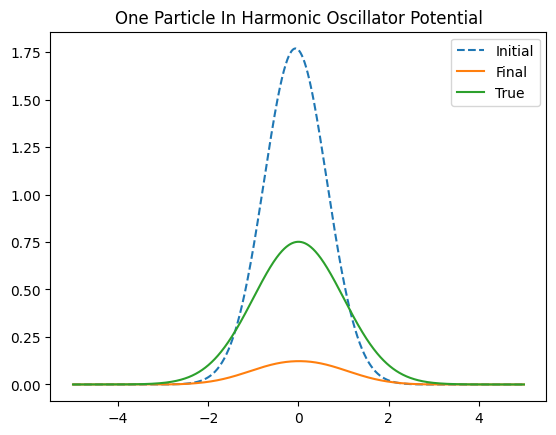

In [33]:
ys = [psi(x, optd[-1]) for x in xs]
yse = [((m*omega)/(np.pi*hbar))**(1/4)*np.exp(-m*omega*x**2/(2*hbar)) for x in xs]
#yse = [np.exp(-x**2) for x in xs]
plt.title(r"One Particle In Harmonic Oscillator Potential")
plt.plot(xs,ysi, "--",label="Initial",)
plt.plot(xs,ys, label="Final")
plt.plot(xs,yse, label="True")
plt.legend()
plt.show()

In [37]:
print("True GS: ", hbar*omega/2)
print("NN GS: ", avg_energy(optd[-1], omega, 10**3))


True GS:  0.5
NN GS:  0.4997852


# [1, 50, 1], 10k iteratons
21m 48.5 seconds (1308.5s)

stabilized at around 4000 iterations

total iterations per second: 7.642

total number of nodes: 52


# [1,50,50, 1], 10k iterations
25m 18s (1518s)

stabilized at around 2000 iterations

total iterations per second: 6.58 

total number of nodes: 102



# [1, 50,50,50,50,50, 1], 10k iterations

60m 16s (3616s)

stabilized at around 750-1000 iterations

total iterations per second: 2.7655

total number of nodes: 252